### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 (or 1/5, 2/5, etc.) (Laughlin state)
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Interaction Details
- **Coulomb Interaction**: V(q) = W₀ × 1/|ql|
- **Gate Screening**: tanh(qD) (finite gate distace)
- **Landau level projection**: exp(-0.5 × q²l²) level form factor
- **Form Factor**: See arXiv.2509.07784 Eq.(A28)
- **Units**: Energy in units of W₀ = e²/ϵl

### Key Physics
- **Periodic boundary conditions**: Torus geometry
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: 3-fold degenerate on torus for 1/3-filling Laughlin states

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum()
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        x = Gk[2] * block_k1[i] + block_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    fig
end

plot_ed_spectrum (generic function with 1 method)

In [2]:
# Define 3×5 k-mesh (Nk=15) for 1/3 filling Laughlin state calculation
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 5          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

5

In [3]:
# Define 3×6 k-mesh (Nk=18) for 1/3 filling Laughlin state calculation
# the three ground states will have the same total momentum

#=

k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

=#

In [4]:
# Define 9×9 k-mesh (Nk=27) for accurate Laughlin state calculation
# the three ground states will have the same total momentum
# Note: This setup needs more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
# Number of electrons for 1/3 filling
Ne = 9          # N electrons for this system

=#

In [5]:
# Define 6×5 k-mesh (Nk=30) for accurate Laughlin state calculation
# Note: This setup needs more time and memory
# Note: 32GB memory is recommended

#=

k_list = [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]

# System parameters
Nk = 30         # Total number of k-points
Gk = (6, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # N electrons for this system

=#

In [ ]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction((1, 0, 1, 0));

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0)
@show intra_PP

# Haldane pseudo-potential
sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
sys_int.V_inter = [1.5; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = k_list, Gk = Gk, V_int = sys_int, FF_inf_angle = LLT.Landau_ff_inf(sys_int));

intra_PP = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637]


In [7]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
display(length.(blocks))

# one-body terms are all zero in flat Landau level
scat = ED_sortedScatteringList_twobody(para);

15-element Vector{Int64}:
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200

In [8]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat; N = Neigen,
        showtime=true
    )
end

Processing block #1 with size 201, momentum 0, 0
  1.072871 seconds (904.23 k allocations: 47.645 MiB, 178.93% compilation time)
  7.216103 seconds (13.45 M allocations: 684.023 MiB, 1.74% gc time, 120.36% compilation time)
Processing block #2 with size 200, momentum 0, 1
  0.012117 seconds (289 allocations: 1.036 MiB)
  0.023635 seconds (3.29 k allocations: 1.540 MiB)
Processing block #3 with size 200, momentum 0, 2
  0.000839 seconds (288 allocations: 1.008 MiB)
  0.012196 seconds (3.54 k allocations: 1.660 MiB)
Processing block #4 with size 200, momentum 0, 3
  0.001145 seconds (263 allocations: 972.979 KiB)
  0.036349 seconds (3.53 k allocations: 1.658 MiB, 82.30% gc time)
Processing block #5 with size 200, momentum 0, 4
  0.000800 seconds (295 allocations: 1.009 MiB)
  0.030392 seconds (3.44 k allocations: 1.568 MiB)
Processing block #6 with size 201, momentum 1, 0
  0.000873 seconds (295 allocations: 1.018 MiB)
  0.010759 seconds (3.79 k allocations: 1.806 MiB)
Processing block #

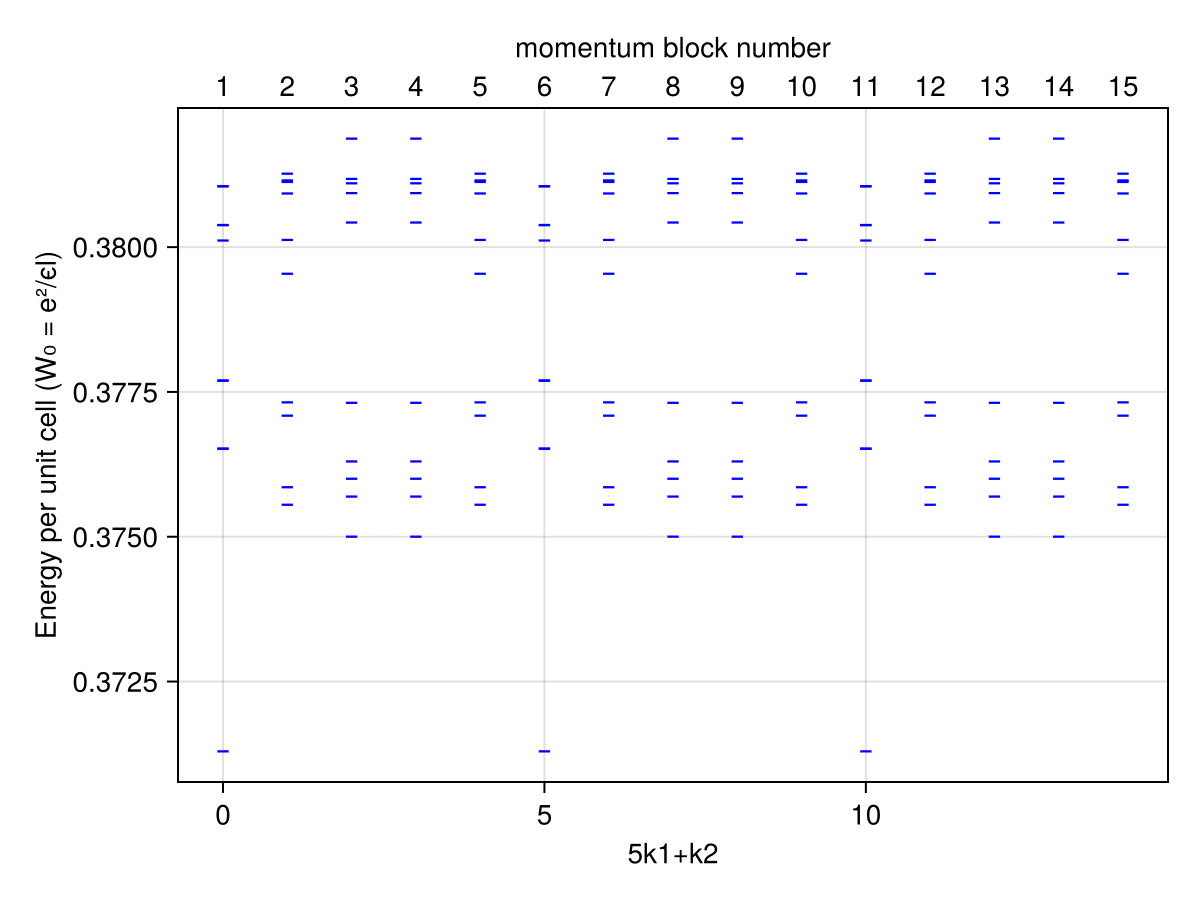

In [9]:
plot_ed_spectrum()

In [10]:
# check energies explicitly to see degeneracy.

bn = 1 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.37129500806589166
 0.3765204279360612
 0.37652042793606155
 0.3776957099170779
 0.37769570991707807
 0.3801142396950236
 0.3803812530904327
 0.3803812530904332
 0.3810509264710961
 0.3810509264710963

Compute and plot one-body reduced density matrix

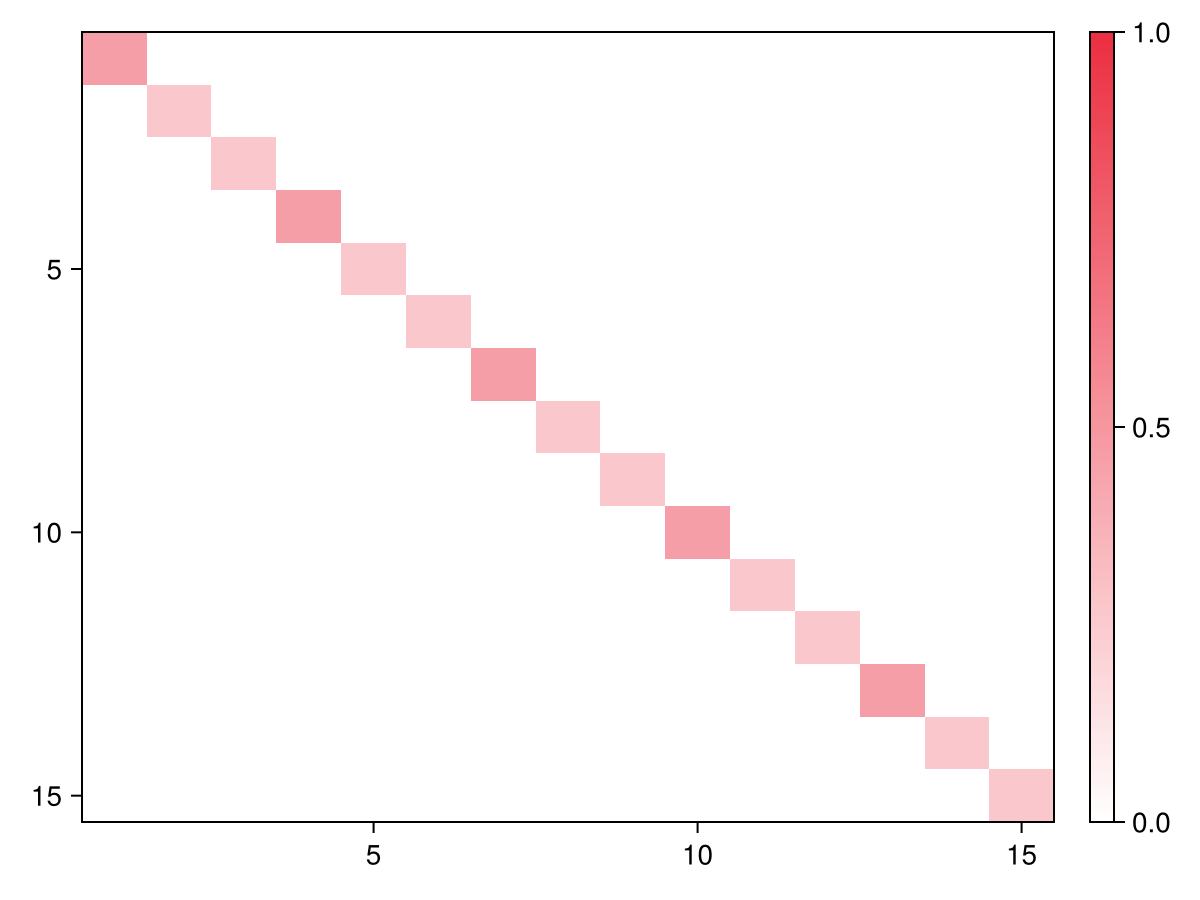

In [11]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [12]:
para.FF_inf_angle = LLT.Landau_ff_inf(sys_int); # Update the form factor in the parameter

# FF_inf_angle can be added after building para. 
# However, assertion for function inputs and output is not triggered. 
# See example 2 for including FF_inf_angle during para initialization.

#8 (generic function with 2 methods)

In [13]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [14]:
bn =  1                    # block number
nstates = 1                # number of degenerating states

psi_before = reduce(hcat, vectors[bn][1:nstates])
ED_connection_gaugefixing!(psi_before)  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatteringList_twobody(para; kshift = path[i+1]);
    vecs = EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    psi_after .= reduce(hcat, vecs)
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 1.0000000000000004, phase = -0.1047197551196619
path point #2 	 (0.1, 0.1)
Inner product: amp = 1.000000000000001, phase = 0.07330382858375381
path point #3 	 (0.0, 0.1)
Inner product: amp = 0.9999999999999996, phase = 0.11519173063164555
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.0000000000000007, phase = -0.06283185307179837


0.3333333333334469

In [15]:
densities = MBSOperator[density_operator(q1, q2, 1, 1; para=para)
    for q1 in -Gk[1]:Gk[1], q2 in -Gk[2]:Gk[2]
]

7×11 Matrix{MBSOperator}:
 MBSOperator{Float64}(Scattering{1}[1-body scattering: c†_out (1,) c_in (1,), Amp = -0.163034+0.0im, 1-body scattering: c†_out (2,) c_in (2,), Amp = 0.0815168+0.0im, 1-body scattering: c†_out (3,) c_in (3,), Amp = 0.0815168+0.0im, 1-body scattering: c†_out (4,) c_in (4,), Amp = -0.0503801+0.0im, 1-body scattering: c†_out (5,) c_in (5,), Amp = -0.109091+0.0im, 1-body scattering: c†_out (6,) c_in (6,), Amp = 0.159471+0.0im, 1-body scattering: c†_out (7,) c_in (7,), Amp = 0.131897+0.0im, 1-body scattering: c†_out (8,) c_in (8,), Amp = -0.148939+0.0im, 1-body scattering: c†_out (9,) c_in (9,), Amp = 0.0170416+0.0im, 1-body scattering: c†_out (10,) c_in (10,), Amp = 0.131897+0.0im, 1-body scattering: c†_out (11,) c_in (11,), Amp = 0.0170416+0.0im, 1-body scattering: c†_out (12,) c_in (12,), Amp = -0.148939+0.0im, 1-body scattering: c†_out (13,) c_in (13,), Amp = -0.0503801+0.0im, 1-body scattering: c†_out (14,) c_in (14,), Amp = 0.159471+0.0im, 1-body scattering: c

In [31]:
bn = 1
mapping = MomentumED.create_state_mapping(blocks[bn])
myvec = MBS64Vector(vectors[bn][1], mapping)

structure_factor = [ begin 
    x = ED_bracket(myvec, densities[Gk[1]+1-q1, Gk[2]+1-q2], densities[Gk[1]+1+q1, Gk[2]+1+q2], myvec)
    if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0
        x = ED_bracket(myvec, densities[Gk[1]+1-q1, Gk[2]+1-q2], myvec) * 
            ED_bracket(myvec, densities[Gk[1]+1+q1, Gk[2]+1+q2], myvec)
    end
    x/Nk
end
    for q1 in -Gk[1]:Gk[1], q2 in -Gk[2]:Gk[2]
]
@show maximum(abs.(imag.(structure_factor)));


DimensionMismatch: DimensionMismatch: The operator scatters the state out of its Hilbert subspace.

In [27]:
real.(structure_factor)[:, 4:8]

7×5 Matrix{Float64}:
 0.0  0.0  6.86562e-33  0.0  0.0
 0.0  0.0  0.0          0.0  0.0
 0.0  0.0  0.0          0.0  0.0
 0.0  0.0  1.66667      0.0  0.0
 0.0  0.0  0.0          0.0  0.0
 0.0  0.0  0.0          0.0  0.0
 0.0  0.0  6.86562e-33  0.0  0.0

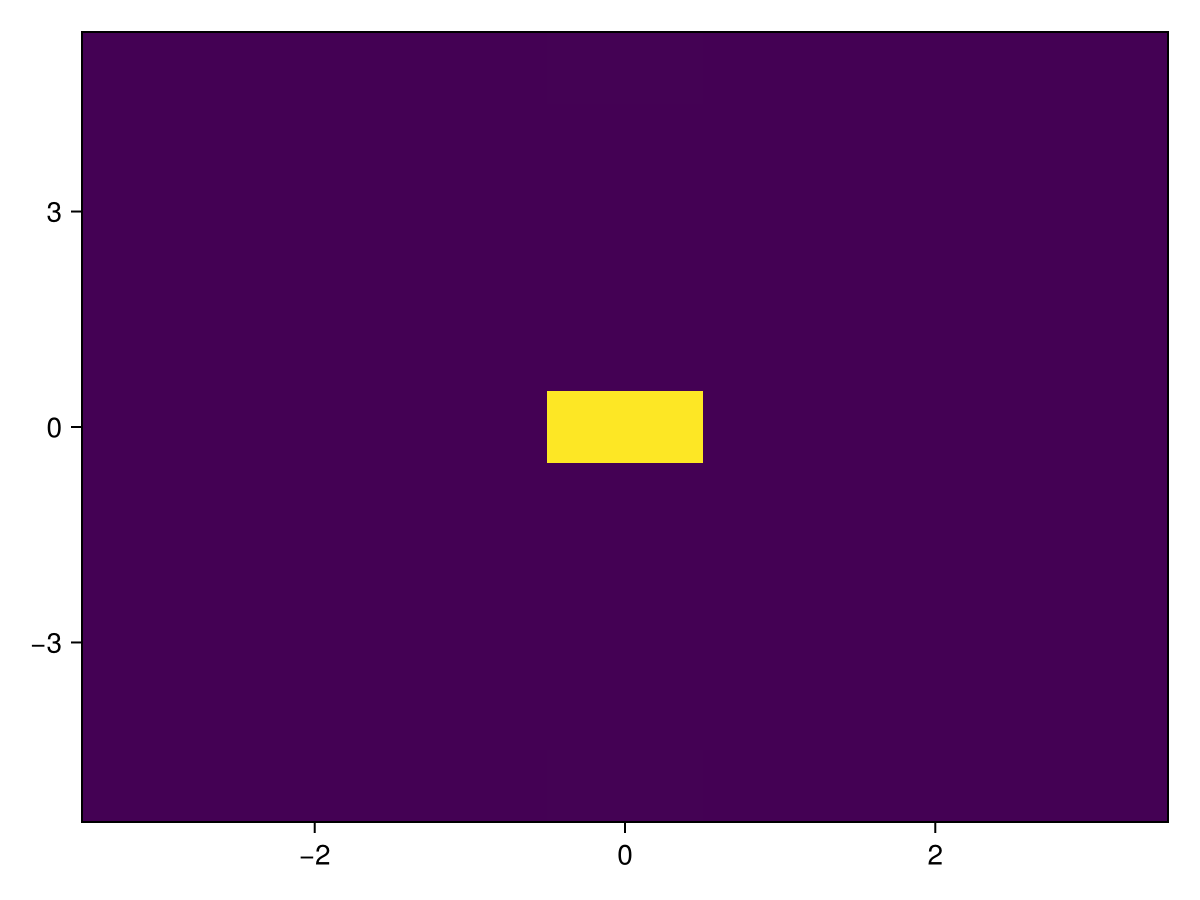

In [24]:
heatmap(-Gk[1]:Gk[1], -Gk[2]:Gk[2], real.(structure_factor))